<a href="https://colab.research.google.com/github/andrew-veriga/sunpower/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

<!-- from astropy.coordinates import get_sun -->

##Получение данных из excel

In [1]:
# !pip install tensorflow-transform

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
tf.__version__

'2.2.0'

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


###Создание датасета

In [5]:
import astropy.units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun

def alt_az(df, longitude, lattitude, height):
  df['Время']= pd.to_timedelta(df['Время'].dt.hour, unit='h')
  df['Дата'] = pd.to_datetime(df['Дата'].dt.date) + df['Время']
  location = EarthLocation(lon=longitude, lat= lattitude, height=height)
  datetimes= Time(df['Дата'])+4*u.hour
  frame = AltAz(obstime=datetimes, location=location)
  sun_altaz=get_sun(datetimes).transform_to(frame)
  df['Sun_alt']= sun_altaz.alt
  df['Sun_az'] = sun_altaz.az


In [6]:
df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_9_Astrakhan_-_gotovo.xlsx", parse_dates=["Дата","Время"],infer_datetime_format=True, index_col=None)
df['Location'] = 'Астрахань'
alt_az(df,46.361433, 48.060790, -20)

df_add =pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_5_Dosang_-_gotovo.xlsx", parse_dates=["Дата","Время"],infer_datetime_format=True, index_col=None)
df_add['Location']='Досанг'
alt_az(df_add, 46.92, 47.93,-19)
df = df.append(df_add)

df_add =pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_6_Kharabali_-_gotovo.xlsx", parse_dates=["Дата","Время"],infer_datetime_format=True, index_col=None)
df_add['Location']='Харабали'
alt_az(df_add,47.411, 47.256, -7)
df = df.append(df_add)

df_add =pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_7_Zelenga_-_gotovo.xlsx", parse_dates=["Дата","Время"],infer_datetime_format=True, index_col=None)
df_add['Location']='Зеленга'
alt_az(df_add,46.171312, 48.603078, -28.00)
df = df.append(df_add)


df_add =pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_1_Cherny_Yar_-_gotovo.xlsx", parse_dates=["Дата","Время"],infer_datetime_format=True, index_col=None)
df_add['Location']='Черный Яр'
alt_az(df_add,48.060120, 46.108620, 1)
df = df.append(df_add)
# Черный яр : 48.060120° с.ш. 46.108620° в.д. высота  1
# Харабали 47.411 47.256 высота -7
# Досанг N 46.92 E 47.93 высота -19
# Астрахань 46.361433 48.060790 -20
# Зеленга широта: 46.171312, долгота: 48.603078 высота над у.м -28.00

# df[df['Location'].isna()]['Location']='Досанг'
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_5_Dosang_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата")
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_6_Kharabali_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_7_Zelenga_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_9_Astrakhan_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))

# pd.to_timedelta(df['Время'].dt.hour, unit='h')


In [7]:
df=df.set_index(['Дата','Location']).drop(columns=['№ п/п','Время']).sort_index()


выровнять данные по дням. В каждом периоде - все локации

In [8]:
new_idx = df.index.levels[0].copy()
# df.reindex(level=1, labels=list(df.index.levels[1]),fill_value=0)
lvl0=new_idx.size
lvl1=df.index.levels[1].size
new_index = pd.MultiIndex.from_arrays([
               np.ravel( np.array([np.repeat(idx,lvl1) for idx in new_idx])),
               np.ravel([np.array(df.index.levels[1]) for i in range(lvl0)]),
               ], names=['Date','Location'],sortorder=0)

df = df.reindex(index=new_index)

In [9]:


df['Wing_cos'] = np.cos(df[ 'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения '])
df['Wing_sin'] = np.sin(df[ 'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения '])
df['Sun_az_sin'] = np.sin(df['Sun_az'])
df['Sun_az_cos'] = np.cos(df['Sun_az'])
df.drop(columns=[
                 'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
                 'Sun_az'
                 ],inplace=True)

numeric_columns=[
            'Мощность, МВт',
            'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
            'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
            # 'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
            'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
            'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
            'Sun_alt',
            'Wing_cos',
            'Wing_sin',
            'Sun_az_sin',
            'Sun_az_cos'
            ]
#df['Время']=[pd.Timedelta(t,'h') for t in df['Время'].dt.hour]
series = df[numeric_columns].fillna(value=0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


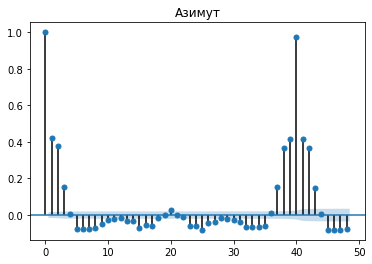

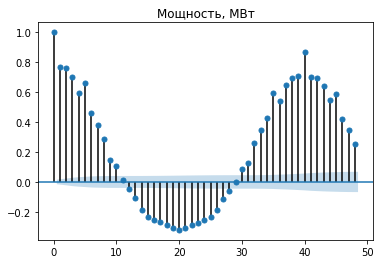

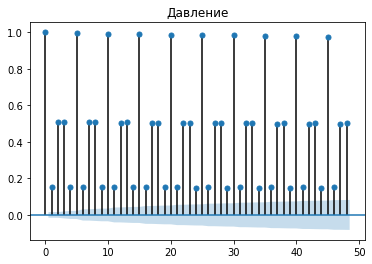

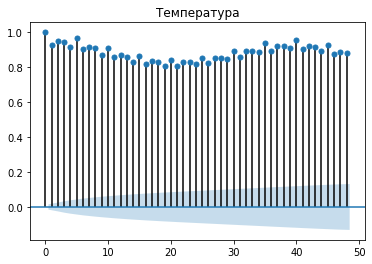

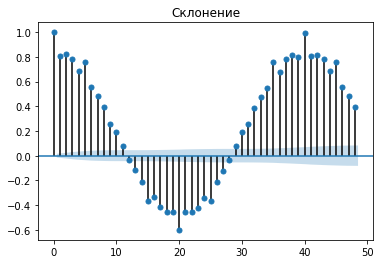

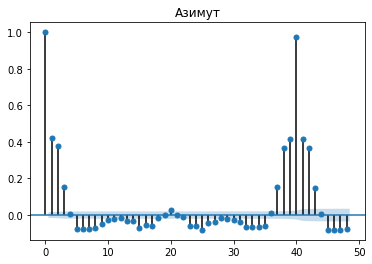

In [10]:

# autocorrelation_plot(series)
# pyplot.show()            
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

lags =48
# size=(250, 100)
# fig = pyplot.figure(figsize=size)
plot_acf( series['Мощность, МВт'], lags=lags,title='Мощность, МВт')
plot_acf( series['Атмосферное давление на уровне станции (миллиметры ртутного столба)'], lags=lags, title='Давление')
plot_acf( series['Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли'], lags=lags, title='Температура')
plot_acf( series['Sun_alt'], lags=lags, title='Склонение')
plot_acf( series['Sun_az_cos'], lags=lags, title='Азимут')


In [11]:
pos = series['Атмосферное давление на уровне станции (миллиметры ртутного столба)'].argmax()

series.iloc[pos-2:pos +2]

Мощность, МВт  ...  Sun_az_cos
Date                Location                  ...            
2019-02-05 16:00:00 Астрахань       1.096056  ...   -0.789815
                    Досанг          0.000000  ...    0.000000
                    Зеленга         1.782222  ...   -0.739872
                    Харабали        5.868778  ...    0.196116

[4 rows x 10 columns]

In [12]:
# добавление one-hot векторов значений для колонок 'Общая облачность' и "Высота облаков"

clouds= df['Общая облачность'].astype('category')
clouds_height=df['Высота основания самых низких облаков (м)'].astype('category')
weather = df['Текущая погода, сообщаемая с метеорологической станции '].fillna(method= 'ffill').astype('category')
# wing_direction = df['Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения '].fillna(value='No').astype('category')
# location = df['Location'].astype('category')
# weather_1 = df['Прошедшая погода между сроками наблюдения 1'].fillna(method= 'ffill').astype('category')
# weather_2 = df['Прошедшая погода между сроками наблюдения 2'].fillna(method= 'ffill').astype('category')

series=pd.concat([
                  series,
                  pd.get_dummies(clouds, prefix='Облака',dummy_na=True).fillna(value=0),
                  pd.get_dummies(clouds_height,prefix='Высота',dummy_na=True).fillna(value=0),
                  pd.get_dummies(weather,prefix='Погода'),
                  # pd.get_dummies(wing_direction, prefix='НаправлениеВетра'),
                  # pd.get_dummies(location, prefix='Loc')
                  # pd.get_dummies(weather_2,prefix='Погода2'),
                  # pd.get_dummies(weather_1,prefix='Погода1')
                  ],axis=1)              




нормализация данных

In [13]:
from sklearn.preprocessing import MinMaxScaler
series['Мощность, МВт']=series['Мощность, МВт'].groupby(level=0).transform(sum)
norm_cols = numeric_columns#[1:]

series[norm_cols] = series[norm_cols].astype('float64')
scaler = MinMaxScaler(feature_range=(0, 1))
series[norm_cols] = scaler.fit_transform(series[norm_cols])


norm_cols

['Мощность, МВт',
 'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
 'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
 'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
 'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
 'Sun_alt',
 'Wing_cos',
 'Wing_sin',
 'Sun_az_sin',
 'Sun_az_cos']

проба из https://www.tensorflow.org/tutorials/structured_data/time_series

In [14]:
### проба из https://www.tensorflow.org/tutorials/structured_data/time_series
def multivariate_data(dataset, target, history_size, target_size=1, 
                       single_step=False):
  data = []
  labels = []
  step=1
  start_index = int(round(history_size))
  target_size = int(round(target_size,0))
  end_index = len(dataset) - target_size
  for i in range(start_index, end_index):
    indices = range(i-start_index, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)
######################################
# past_history = 24/3*2
# future_target = 24/3
# STEP = 1
# ds= series[:100].values
# target = series['Мощность, МВт'].values
# x_train_single, y_train_single = multivariate_data(ds, target, past_history, future_target, single_step=False)

###Оформление оконного датасета

многомерный вектор состояния погоды

In [15]:
#import tensorflow_transform as tft

tf.keras.backend.clear_session()

def multiwindowed_dataset(table, targ_column, window_size, batch_size, shuffle_buffer=0):
  # target_col=series.columns.get_loc(target)
  dataset = tf.data.Dataset.from_tensor_slices(table)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1,...,np.newaxis], window[-1,:,targ_column][0]))
  if shuffle_buffer > 0: #for training regime only
    dataset = dataset.shuffle(shuffle_buffer)
  
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

newshape=[series.index.levels[0].size,series.index.levels[1].size,series.columns.size]
Srs_ds = series.sort_index().values.reshape(newshape)
targ_column = series.columns.get_loc('Мощность, МВт')
Target = Srs_ds[:,:,targ_column]



window_size = int(24/3*2)
batch_size = 240
shuffle_buffer = 1000

train_batches = int(series.index.levels[0].size / batch_size * .9)
# target = 'Мощность, МВт'



dataset = multiwindowed_dataset(Srs_ds, targ_column, window_size, batch_size, shuffle_buffer)
train = dataset.take(train_batches)
validation = dataset.skip(train_batches)



##Сборка и тренировка модели

In [16]:
list(train.element_spec[0].shape)

[None, None, 5, 163, 1]

In [17]:
import tensorflow.keras.layers as lr
tf.random.set_seed(51)
np.random.seed(51)


model = tf.keras.models.Sequential([
      lr.TimeDistributed( lr.Conv2D(128,(1,20), activation='relu'),input_shape= list(train.element_spec[0].shape[1:])),
      #lr.TimeDistributed( lr.MaxPooling2D((2,10))),
      lr.TimeDistributed( lr.Conv2D(64, (2,5), activation='relu')),
      lr.TimeDistributed(  lr.MaxPooling2D((2,2),strides=(1,5))),
      lr.TimeDistributed(lr.Flatten()),#GlobalAveragePooling2D()),
      #lr.Conv2DLSTM()
      lr.Bidirectional(lr.GRU(60, return_sequences=True)),
      lr.Bidirectional(lr.GRU(20, return_sequences=False)),
      # lr.Dense(1, activation='linear'),
      lr.Dense(1, activation='linear')
])


# Model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=128, kernel_size=2,
#                     strides=1, padding= "causal",
#                     activation="sigmoid",
#                     input_shape=[None, series.shape[1]]),
#     tf.keras.layers.MaxPooling1D(pool_size=2),
#     tf.keras.layers.Conv1D(filters=64, kernel_size=2,
#                     strides=1, padding= "causal",
#                     activation="relu",
#                     ),
#     tf.keras.layers.MaxPooling1D(pool_size=2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(60, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3))),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20,dropout=0.5)),
#     tf.keras.layers.Dropout(0.7),
#     tf.keras.layers.Dense(1)#, bias_constraint= tf.keras.constraints.non_neg(), kernel_constraint=tf.keras.constraints.non_neg())
#   ])

  
optimizer = tf.keras.optimizers.Adam(lr=0.003)
model.compile(loss="mae", optimizer=optimizer, sample_weight_mode='temporal', metrics=['mse'])
  

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 5, 144, 128) 2688      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 4, 140, 64)  81984     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 3, 28, 64)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 5376)        0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 120)         1957680   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                17040     
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [19]:
init_lr =1e-5
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: init_lr * 10**(epoch / 20))

epoch_num= 250
history = model.fit(train, validation_data=(validation) , epochs=epoch_num)#, callbacks=[lr_schedule])

Epoch 1/250
12/12 [==============================] - 17s 1s/step - loss: 0.2329 - mse: 0.1277 - val_loss: 0.1134 - val_mse: 0.0439
Epoch 2/250
12/12 [==============================] - 15s 1s/step - loss: 0.1618 - mse: 0.0817 - val_loss: 0.1112 - val_mse: 0.0505
Epoch 3/250
12/12 [==============================] - 15s 1s/step - loss: 0.1515 - mse: 0.0655 - val_loss: 0.0899 - val_mse: 0.0318
Epoch 4/250
12/12 [==============================] - 15s 1s/step - loss: 0.1256 - mse: 0.0413 - val_loss: 0.0844 - val_mse: 0.0166
Epoch 5/250
12/12 [==============================] - 15s 1s/step - loss: 0.0949 - mse: 0.0173 - val_loss: 0.0861 - val_mse: 0.0223
Epoch 6/250
12/12 [==============================] - 16s 1s/step - loss: 0.0933 - mse: 0.0186 - val_loss: 0.0639 - val_mse: 0.0093
Epoch 7/250
12/12 [==============================] - 15s 1s/step - loss: 0.0799 - mse: 0.0129 - val_loss: 0.0570 - val_mse: 0.0068
Epoch 8/250
12/12 [==============================] - 15s 1s/step - loss: 0.0740 - m

In [20]:
#анализ скорости обучения
 
# lrs = init_lr * (10 ** (np.arange(len(history.history['loss'])-5) / 20))
# plt.semilogx(lrs, history.history['val_loss'][:-5])
# plt.semilogx(lrs, history.history["loss"][:-5])
# plt.axis([1e-6, 200, 0, 20])

###Анализ функции потерь

In [21]:
# history = Model.fit(train, validation_data=(validation), epochs=epoch_num+20, initial_epoch=epoch_num, callbacks=[lr_schedule])

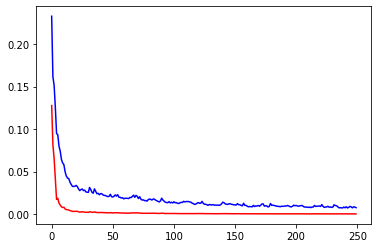

In [22]:
loss = history.history['loss']
mse = history.history['mse']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, mse, 'r', label='Training mae')

plt.show()

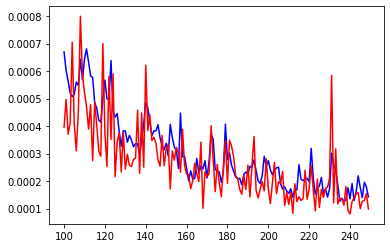

In [23]:
# Plot all but the first 10
skip_steps=100
loss = history.history['mse']
mse = history.history['val_mse']

epochs = range(skip_steps, len(loss))
plot_loss = loss[skip_steps:]
plot_mae = mse[skip_steps:]

plt.plot(epochs, plot_loss, 'b', label='Training mse')
plt.plot(epochs, plot_mae, 'r', label='Val mse')

plt.show()

<Figure size 432x288 with 0 Axes>

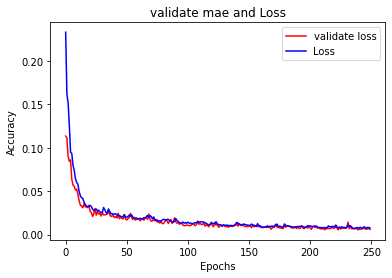

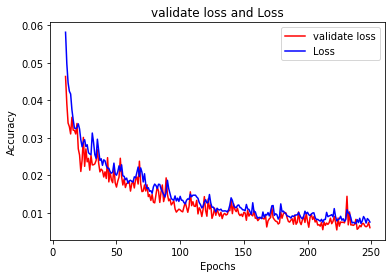

<Figure size 432x288 with 0 Axes>

In [24]:
val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot validate loss and Loss
#------------------------------------------------
plt.plot(epochs, val_loss, 'r')
plt.plot(epochs, loss, 'b')
plt.title('validate mae and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

epochs_zoom = epochs[10:]
mae_zoom = val_loss[10:]
loss_zoom = loss[10:]

#------------------------------------------------
# Plot Zoomed validate loss and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

### График сравнения предсказанной мощности с реальной, взятой из таблицы

метрика 

In [26]:
from sklearn.metrics import mean_squared_error
# Srs_ds = series.sort_index().values.reshape(newshape)
# targ_column = series.columns.get_loc('Мощность, МВт')
# Target = Srs_ds[:,:,targ_column]
split_pos = int(series.index.levels[0].size * .9)

actual_data = Srs_ds[split_pos:]
# forecast=model_forecast(Model, series[split_datetime-window_size:], window_size)
forecast = model.predict(multiwindowed_dataset(actual_data, targ_column, window_size, batch_size))
# invert scaling for forecast
test_index = series.index.levels[0][split_pos+window_size:]


forecast = pd.DataFrame(forecast,index=test_index)
old_values = series.loc[test_index][norm_cols]
new_values = forecast.join(series.loc[test_index][norm_cols])
new_values['Мощность, МВт']=new_values[0]
new_values = new_values.drop(columns=0)

npidx = range(0, len(old_values),lvl1)

actuals = scaler.inverse_transform(old_values)[npidx,0]

results = scaler.inverse_transform(new_values)[npidx,0]

# calculate RMSE
rmse = mean_squared_error(actuals, results)
print('Test RMSE: %.3f' % rmse)



Test RMSE: 0.426


In [27]:
def plot_series(time, series, format="-", start=0, end=None, legend=None):
    plt.plot(time[start:end], series[start:end], format )
    plt.xlabel("Time")
    plt.ylabel("Value")
    # plt.legend(legend)
    plt.grid(True)

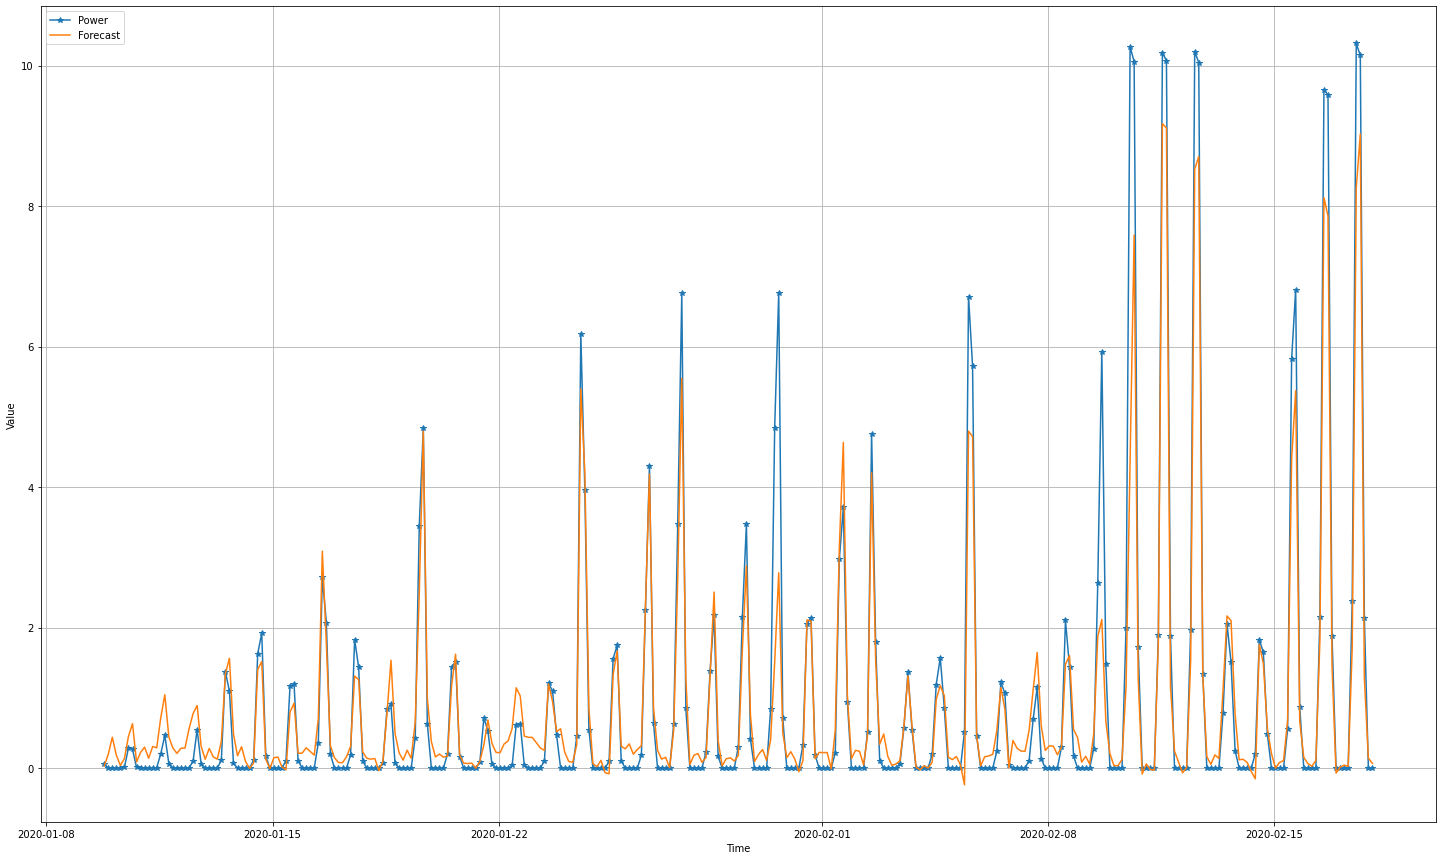

In [28]:
#import matplotlib.pyplot as plt

time_train = test_index#.to_numpy(dtype=np.datetime64)
plt.figure(figsize=(25, 15))
# plt.ylim(top=2)
plot_series(time_train, actuals, format='-*')#,start=200)#,end=200)
plot_series(time_train, results)#,start=200)#,end=200)
plt.legend(['Power', 'Forecast'])

In [ ]:
add_epoch_num=100

history= model.fit(x=x_train,y=y_train, validation_data=(x_test, y_test), epochs=epoch_num + add_epoch_num, initial_epoch=epoch_num )
epoch_num = epoch_num + add_epoch_num